In [16]:
from transformers import GPT2LMHeadModel

In [17]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")  # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

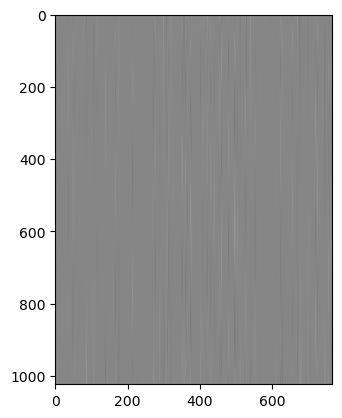

In [18]:
import matplotlib.pyplot as plt

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

Text(0, 0.5, 'weights')

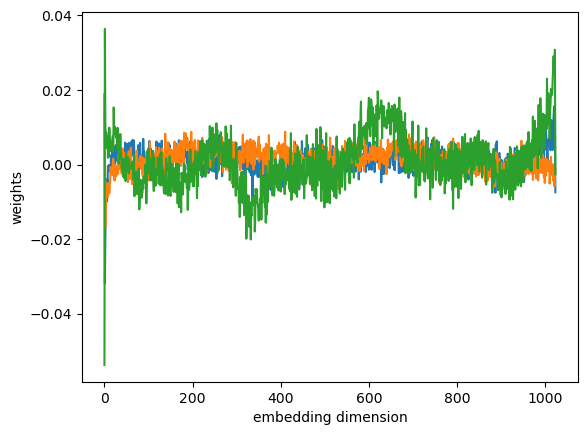

In [19]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 50])
plt.plot(sd_hf["transformer.wpe.weight"][:, 100])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.xlabel("embedding dimension")
plt.ylabel("weights")

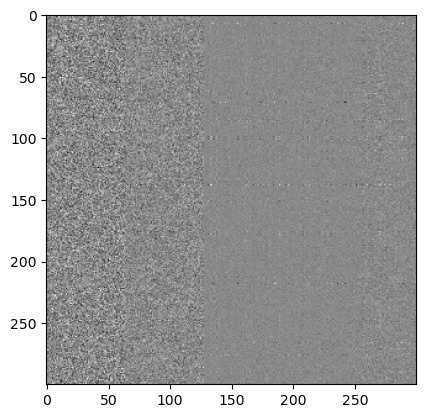

In [20]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray")

In [21]:
from transformers import pipeline, set_seed

generator = pipeline("text-generation", model="gpt2")

set_seed(42)
generator("Hello, I'm a large language model", max_length=30, num_return_sequences=5)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a large language model for you. It's something I really feel like I would like to do in a future app.\n\n"},
 {'generated_text': "Hello, I'm a large language model. The real problem is I don't know how to do anything, so it's a whole different world when"},
 {'generated_text': "Hello, I'm a large language model for the whole world. I'm also interested in some general data analysis and statistics as seen by mathematicians and"},
 {'generated_text': "Hello, I'm a large language model for people that can think of much different languages than what I did originally. Like, when someone is starting a"},
 {'generated_text': "Hello, I'm a large language modeler, I can draw on all of my own programming knowledge in an interesting manner and I know how to create"}]

In [31]:
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

response = requests.get(url)

if response.status_code == 200:

    with open("input.txt", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("Shakespeare data saved!")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Shakespeare data saved!


In [24]:
with open("input.txt", "r") as file:
    text = file.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [25]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


We want to get the shakespeare data into the format of (B, T). i.e. batches of sequences of tokens.

In [26]:
import torch
buf = torch.tensor(tokens[:24 + 1]) # +1 for label tensor
x = buf[:-1].view(4, 6) # Create inputs to transformer
y = buf[1:].view(4, 6) # Create labels tensor
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [27]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [28]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

tensor(True)

In [29]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

125328903110720
125328903110720


In [30]:
# standard deviation grows inside the residual stream
# scale dow c_proj
x = torch.zeros(768)
n = 100
for i in range(n):
    x += n**-0.5 * torch.randn(768)
print(x.std())

tensor(0.9850)
